In [68]:
# Librerias:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc, confusion_matrix

import matplotlib.pyplot as plt

In [69]:
# Guardar los datos en variables:
x_data = pd.read_csv('C:/Users/Diego/OneDrive - Universidad Rey Juan Carlos/Documentos/GIA_URJC/Curso 2023-24/G.-IA/Curso_2/Cuatri_2/AprendizajeAutomatico_1/Practicas/Practica_1/Datos/trainX_reto1.csv', sep=';', decimal='.', index_col=0, na_values='?')
y_data = pd.read_csv('C:/Users/Diego/OneDrive - Universidad Rey Juan Carlos/Documentos/GIA_URJC/Curso 2023-24/G.-IA/Curso_2/Cuatri_2/AprendizajeAutomatico_1/Practicas/Practica_1/Datos/trainY_reto1.csv', sep=';', decimal='.', index_col=0, na_values='?')

In [70]:
# Separación en train y test:
random_state = 15
x_train, x_test = train_test_split(x_data, test_size=0.2, random_state=random_state)
y_train, y_test = train_test_split(y_data, test_size=0.2, random_state=random_state)

# Ordenar los df por id:
x_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)

# Limpieza de datos:

In [71]:
# Exploración de datos:
print(x_train.info())
print(x_train.describe())
print('\nModas:\n', x_train.mode(axis=0, dropna=False))
N_x, D_x = x_train.shape

print('\n\n', y_train.info())
print(y_train.describe())
N_y, D_y = y_train.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 1 to 399
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     249 non-null    float64
 1   bp      250 non-null    float64
 2   sg      228 non-null    float64
 3   al      230 non-null    float64
 4   su      229 non-null    float64
 5   rbc     156 non-null    object 
 6   pc      218 non-null    object 
 7   pcc     255 non-null    object 
 8   ba      255 non-null    object 
 9   bgr     225 non-null    float64
 10  bu      243 non-null    float64
 11  sc      244 non-null    float64
 12  sod     199 non-null    float64
 13  pot     198 non-null    float64
 14  hemo    225 non-null    float64
 15  pcv     209 non-null    float64
 16  wbcc    188 non-null    float64
 17  rbcc    167 non-null    float64
 18  htn     254 non-null    object 
 19  dm      254 non-null    object 
 20  cad     254 non-null    object 
 21  appet   255 non-null    object 
 22  pe

In [72]:
#-- CODIFICACIÓN DE LOS DATOS --#

# Creas una copia del DataFrame original:
x_train_copy = x_train.copy()
y_train_copy = y_train.copy()

def encode_col(df):
    le = LabelEncoder()  # Inicializa un LabelEncoder
    encoding_dict = {}  # Inicializa un diccionario para guardar los mapeos

    # Itera sobre cada columna en el DataFrame
    for col in df.columns:
        if df[col].dtype == 'object':  # Verifica si la columna es de tipo 'object'
            non_nan_values = df[col].dropna()  # Elimina los valores NaN de la columna
            if non_nan_values.empty:
                continue  # Si no hay valores no nulos en la columna, continúa con la siguiente columna
            df[col] = df[col].map(lambda x: le.fit(non_nan_values).transform([x])[0] if pd.notnull(x) else np.nan)  # Ajusta el LabelEncoder y transforma la columna
            encoding_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))  # Guarda el mapeo de la columna en el diccionario
    
    return df, encoding_dict


x_train_df, encoding_dict_x = encode_col(x_train_copy)
y_train_df, encoding_dict_y = encode_col(y_train_copy)

print('Dicc. encoding_dict_x: ', encoding_dict_x)
print('Dicc. encoding_dict_y: ', encoding_dict_y)

Dicc. encoding_dict_x:  {'rbc': {'abnormal': 0, 'normal': 1}, 'pc': {'abnormal': 0, 'normal': 1}, 'pcc': {'notpresent': 0, 'present': 1}, 'ba': {'notpresent': 0, 'present': 1}, 'htn': {'no': 0, 'yes': 1}, 'dm': {'no': 0, 'yes': 1}, 'cad': {'no': 0, 'yes': 1}, 'appet': {'good': 0, 'poor': 1}, 'pe': {'no': 0, 'yes': 1}, 'ane': {'no': 0, 'yes': 1}}
Dicc. encoding_dict_y:  {'class': {'ckd': 0, 'notckd': 1}}


In [73]:
# Visualización de valores NaN:
missig_data = x_train_df.isna()

missing_values_column = missig_data.sum(axis=0)
missing_values_row = missig_data.sum(axis=1)

mask_mayorq0 = missing_values_column > 0
mask_mayorq1 = missing_values_row > 0

print(f'Columnas con valores nulos:\n{missing_values_column[mask_mayorq0]}\n')
print(f'Filas con valores nulos:\n{missing_values_row[mask_mayorq1]}\n')

missing_count_row = missing_values_row.value_counts().sort_index()
print(f'Valores NaN en cada fila:\n{missing_count_row}')
missing_count_col = missing_values_column.value_counts().sort_index()
print(f'Valores NaN en cada columna:\n{missing_count_col}')

Columnas con valores nulos:
age        7
bp         6
sg        28
al        26
su        27
rbc      100
pc        38
pcc        1
ba         1
bgr       31
bu        13
sc        12
sod       57
pot       58
hemo      31
pcv       47
wbcc      68
rbcc      89
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64

Filas con valores nulos:
1      5
2      3
4      2
6      3
7      3
      ..
349    2
350    2
365    2
378    2
381    2
Length: 156, dtype: int64

Valores NaN en cada fila:
0     100
1      31
2      25
3      20
4      21
5      20
6       5
7      12
8       4
9       8
10      4
11      6
dtype: int64
Valores NaN en cada columna:
1      5
2      3
6      1
7      1
12     1
13     1
26     1
27     1
28     1
31     2
38     1
47     1
57     1
58     1
68     1
89     1
100    1
dtype: int64


In [74]:
# Crear columna dummies valores NaN
for col in x_train_df.columns:
    x_train_df[col + '_isna'] = x_train_df[col].isna().astype(int)

# Sustitución de valores NaN por valor 'mean' columnas 'rbc':
mean_rbc = x_train_df['rbc'].mean()
x_train_df['rbc'].fillna(mean_rbc, inplace=True)

In [75]:
#-- IMPUTACIÓN MULTIVARIANTE --#

# Creas una copia del DataFrame original:
x_train_df_copy = x_train_df.copy()

# Imputación multivariante de los datos NaN:
imputer = IterativeImputer()
train_imputed = imputer.fit_transform(x_train_df_copy)
x_train_df = pd.DataFrame(train_imputed, columns=x_train_df_copy.columns)              # Convertir de nuevo a DataFrame
print(x_train_df.isna().sum())   
print('\nTamaño x_train_df: ', x_train_df.shape)


age           0
bp            0
sg            0
al            0
su            0
rbc           0
pc            0
pcc           0
ba            0
bgr           0
bu            0
sc            0
sod           0
pot           0
hemo          0
pcv           0
wbcc          0
rbcc          0
htn           0
dm            0
cad           0
appet         0
pe            0
ane           0
age_isna      0
bp_isna       0
sg_isna       0
al_isna       0
su_isna       0
rbc_isna      0
pc_isna       0
pcc_isna      0
ba_isna       0
bgr_isna      0
bu_isna       0
sc_isna       0
sod_isna      0
pot_isna      0
hemo_isna     0
pcv_isna      0
wbcc_isna     0
rbcc_isna     0
htn_isna      0
dm_isna       0
cad_isna      0
appet_isna    0
pe_isna       0
ane_isna      0
dtype: int64

Tamaño x_train_df:  (256, 48)


In [76]:
# Aumento de dimensionalidad:
degree = 2
interaction_only = True

polyf = PolynomialFeatures(degree=degree, interaction_only=interaction_only)
polyf.set_output(transform="pandas")

x_train_dim = polyf.fit_transform(x_train_df)
print('Tamaño x_train_dim: ',x_train_dim.shape)


Tamaño x_train_dim:  (256, 1177)


In [77]:
#-- Escalados a intervalos diferentes --#

# Escalado a intervalo unidad [0,1]:
scalerUnit = MinMaxScaler()
x_train_dim_unit = scalerUnit.fit_transform(x_train_dim)

# Escalado al máx. de los valores abs.:
scalerMaxAbs = MaxAbsScaler()
x_train_dim_MaxAbs = scalerMaxAbs.fit_transform(x_train_dim)

# Estandarizamos:
scalerStd = StandardScaler()
x_train_dim_std = scalerStd.fit_transform(x_train_dim)

In [78]:
#-- FILTRADO --#

# Filtrado por varianza:
selector_var = VarianceThreshold()
selector_var.set_output(transform="pandas")

x_train_unit_var = selector_var.fit_transform(x_train_dim_unit)
x_train_MaxAbs_var = selector_var.fit_transform(x_train_dim_MaxAbs)
x_train_sdt_var = selector_var.fit_transform(x_train_dim_std)

# Filtrado por correlación:

def drop_highly_correlated_columns(df):
    df = pd.DataFrame(df)   # Crea un DataFrame de pandas
    df_corr = df.corr().abs()  # Calculas la matriz de correlación
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))    # Seleccionas el triángulo superior de la matriz de correlación
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]  # Encuentras las columnas con correlación mayor a 0.9 (puedes ajustar este valor a tus necesidades)    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    col_dropped = list(to_drop) # Guarda la lista de columnas eliminadas
    df_ret = df.drop(col_dropped, axis=1)    # Eliminas las columnas altamente correlacionadas
    return df_ret, col_dropped

x_train_corr, col_drop_corr = drop_highly_correlated_columns(x_train_dim)
x_train_unit_corr, col_drop_unit = drop_highly_correlated_columns(x_train_dim_unit)
x_train_MaxAbs_corr, col_drop_MaxAbs = drop_highly_correlated_columns(x_train_dim_MaxAbs)
x_train_std_corr, col_drop_std = drop_highly_correlated_columns(x_train_dim_std)

In [79]:
#-- ENTRENAMOS LOS MODELOS LINEALES --#
reg_model_unit = linear_model.LinearRegression()
reg_model_unit.fit(x_train_unit_var, y_train_df['class'])

reg_model_MaxAbs = linear_model.LinearRegression()
reg_model_MaxAbs.fit(x_train_MaxAbs_var, y_train_df['class'])

reg_model_std = linear_model.LinearRegression()
reg_model_std.fit(x_train_sdt_var, y_train_df['class'])

reg_model_corr = linear_model.LinearRegression()
reg_model_corr.fit(x_train_corr, y_train_df['class'])

reg_model_unit_corr = linear_model.LinearRegression()
reg_model_unit_corr.fit(x_train_unit_corr, y_train_df['class'])

reg_model_MaxAbs_corr = linear_model.LinearRegression()
reg_model_MaxAbs_corr.fit(x_train_MaxAbs_corr, y_train_df['class'])

reg_model_std_corr = linear_model.LinearRegression()
reg_model_std_corr.fit(x_train_std_corr, y_train_df['class'])

LinearRegression()

Tamaño del DataFrame original:  (256, 48)
Tamaño del nuevo DataFrame:  (256, 23) 

Tabla con los componentes principales hasta explicar el 90.0% de la varianza


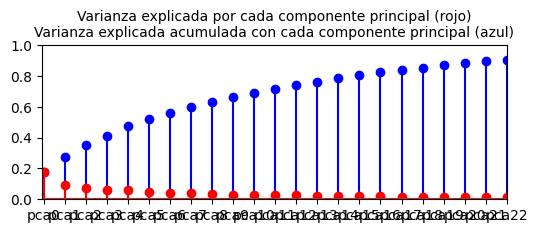

LinearRegression()

In [80]:
#-- PCA --#

# Estandarizamos primero:
print('Tamaño del DataFrame original: ', x_train_df.shape)
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(x_train_df)
x_train_df_std = scaler.transform(x_train_df)

# PCA seleccionando diréctamente el número de componentes o un porcentaje de información que queremos mantener:
n_components = 0.90 # si se pone un núm. entero (3) sería el núm. de columnas que mantendríamos

pca = PCA(n_components= n_components).set_output(transform='pandas')
pca.fit(x_train_df_std)
x_train_pca = pca.transform(x_train_df_std)

print('Tamaño del nuevo DataFrame: ', x_train_pca.shape, f'\n\nTabla con los componentes principales hasta explicar el {n_components*100}% de la varianza')

# Visualización del peso de cada columna calculada:
def plot_PCA(pca):
  plt.stem(pca.explained_variance_ratio_.cumsum(),'b')
  plt.stem(pca.explained_variance_ratio_,'r')

  titleStr = 'Varianza explicada por cada componente principal (rojo)'
  titleStr = titleStr+'\n'
  titleStr = titleStr+'Varianza explicada acumulada con cada componente principal (azul)'
  plt.title(titleStr, fontsize=10)
  ax = plt.gca()
  ax.axis([-0.1,1.1,0,1])
  ax.set_xticks([i for i in range(pca.n_components_)])
  ax.set_xticklabels(["pca"+str(i) for i in range(pca.n_components_)])

  fig = plt.gcf()
  fig.set_size_inches(6,2)

  plt.show()

plot_PCA(pca)

# Entrenamos el modelo con X_train_var_filtered:
reg_model_pca = linear_model.LinearRegression()
reg_model_pca.fit(x_train_pca, y_train_df['class'])

# Limpiamos el test:

In [81]:
# Exploración de datos:
print(x_test.info())
print(x_test.describe())
print('\nModas:\n', x_test.mode(axis=0, dropna=False))
N_x, D_x = x_test.shape

print('\n\n', y_test.info())
print(y_test.describe())
N_y, D_y = y_test.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 392 to 110
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     64 non-null     float64
 1   bp      61 non-null     float64
 2   sg      61 non-null     float64
 3   al      59 non-null     float64
 4   su      58 non-null     float64
 5   rbc     44 non-null     object 
 6   pc      56 non-null     object 
 7   pcc     62 non-null     object 
 8   ba      62 non-null     object 
 9   bgr     59 non-null     float64
 10  bu      61 non-null     float64
 11  sc      62 non-null     float64
 12  sod     51 non-null     float64
 13  pot     51 non-null     float64
 14  hemo    56 non-null     float64
 15  pcv     54 non-null     float64
 16  wbcc    49 non-null     float64
 17  rbcc    47 non-null     float64
 18  htn     64 non-null     object 
 19  dm      64 non-null     object 
 20  cad     64 non-null     object 
 21  appet   64 non-null     object 
 22  p

In [82]:
# Codificación de los datos:
def apply_encoding(df_test, encoding_dict):
    for col, mapping in encoding_dict.items():
        df_test[col] = df_test[col].map(lambda x: mapping.get(x, x))
    return df_test

x_test_df = apply_encoding(x_test, encoding_dict_x)
y_test_df = apply_encoding(y_test, encoding_dict_y)


In [83]:
# Visualización de valores NaN:
missig_data = x_test_df.isna()

missing_values_column = missig_data.sum(axis=0)
missing_values_row = missig_data.sum(axis=1)

mask_mayorq0 = missing_values_column > 0
mask_mayorq1 = missing_values_row > 0

print(f'Columnas con valores nulos:\n{missing_values_column[mask_mayorq0]}\n')
print(f'Filas con valores nulos:\n{missing_values_row[mask_mayorq1]}\n')

missing_count_row = missing_values_row.value_counts().sort_index()
print(f'Valores NaN en cada fila:\n{missing_count_row}')
missing_count_col = missing_values_column.value_counts().sort_index()
print(f'Valores NaN en cada columna:\n{missing_count_col}')

Columnas con valores nulos:
bp       3
sg       3
al       5
su       6
rbc     20
pc       8
pcc      2
ba       2
bgr      5
bu       3
sc       2
sod     13
pot     13
hemo     8
pcv     10
wbcc    15
rbcc    17
dtype: int64

Filas con valores nulos:
219    3
328    3
173    1
201    7
232    9
134    4
13     8
105    1
336    2
216    6
69     3
287    2
293    1
233    4
0      3
54     3
8      2
295    5
164    3
156    7
221    5
199    1
316    3
65     6
239    2
332    1
53     4
363    2
194    9
83     4
136    6
129    4
217    1
124    3
178    1
60     5
110    1
dtype: int64

Valores NaN en cada fila:
0    27
1     8
2     5
3     8
4     5
5     3
6     3
7     2
8     1
9     2
dtype: int64
Valores NaN en cada columna:
0     7
2     3
3     3
5     2
6     1
8     2
10    1
13    2
15    1
17    1
20    1
dtype: int64


In [84]:
# Crear columna dummies valores NaN
for col in x_test_df.columns:
    x_test_df[col + '_isna'] = x_test_df[col].isna().astype(int)

# Sustitución de valores NaN por valor 'mean' columnas 'rbc':
mean_rbc = x_test_df['rbc'].mean()
x_test_df['rbc'].fillna(mean_rbc, inplace=True)

#-- IMPUTACIÓN MULTIVARIANTE --#

# Creas una copia del DataFrame original:
x_test_df_copy = x_test_df.copy()

# Imputación multivariante de los datos NaN:
test_imputed = imputer.transform(x_test_df_copy)
x_test_df = pd.DataFrame(test_imputed, columns=x_test_df_copy.columns)              # Convertir de nuevo a DataFrame
print(x_test_df.isna().sum())   
print('\nTamaño x_test_df: ', x_test_df.shape)

age           0
bp            0
sg            0
al            0
su            0
rbc           0
pc            0
pcc           0
ba            0
bgr           0
bu            0
sc            0
sod           0
pot           0
hemo          0
pcv           0
wbcc          0
rbcc          0
htn           0
dm            0
cad           0
appet         0
pe            0
ane           0
age_isna      0
bp_isna       0
sg_isna       0
al_isna       0
su_isna       0
rbc_isna      0
pc_isna       0
pcc_isna      0
ba_isna       0
bgr_isna      0
bu_isna       0
sc_isna       0
sod_isna      0
pot_isna      0
hemo_isna     0
pcv_isna      0
wbcc_isna     0
rbcc_isna     0
htn_isna      0
dm_isna       0
cad_isna      0
appet_isna    0
pe_isna       0
ane_isna      0
dtype: int64

Tamaño x_test_df:  (64, 48)


In [85]:
# Aumento de dimensionalidad:
x_test_dim = polyf.transform(x_test_df)
print('Tamaño x_test_dim: ',x_test_dim.shape)

#-- Escalados a intervalos diferentes --#

# Escalado a intervalo unidad [0,1]:
x_test_dim_unit = scalerUnit.transform(x_test_dim)

# Escalado al máx. de los valores abs.:
x_test_dim_MaxAbs = scalerMaxAbs.transform(x_test_dim)

# Estandarizamos:
x_test_dim_std = scalerStd.transform(x_test_dim)

Tamaño x_test_dim:  (64, 1177)


In [86]:
#-- FILTRADO --#

# Filtrado por varianza:
# x_test_var = selector_var.transform(x_test_dim)
x_test_unit_var = selector_var.transform(x_test_dim_unit)
x_test_MaxAbs_var = selector_var.transform(x_test_dim_MaxAbs)
x_test_sdt_var = selector_var.transform(x_test_dim_std)

# Filtrado por correlación:
def drop_col_test(df, l_col):
    df = pd.DataFrame(df)
    return df.drop(columns=l_col)

x_test_corr = drop_col_test(x_test_dim, col_drop_corr)
x_test_unit_corr = drop_col_test(x_test_dim_unit, col_drop_unit)
x_test_MaxAbs_corr = drop_col_test(x_test_dim_MaxAbs, col_drop_MaxAbs)
x_test_std_corr = drop_col_test(x_test_dim_std, col_drop_std)

In [87]:
print('x_train_unit_var', x_train_unit_var.shape)
print('x_train_MaxAbs_var', x_train_MaxAbs_var.shape)
print('x_train_sdt_var', x_train_sdt_var.shape)
print('x_train_corr', x_train_corr.shape)
print('x_train_unit_corr', x_train_unit_corr.shape)
print('x_train_MaxAbs_corr', x_train_MaxAbs_corr.shape)
print('x_train_std_corr', x_train_std_corr.shape)

x_train_unit_var (256, 936)
x_train_MaxAbs_var (256, 936)
x_train_sdt_var (256, 936)
x_train_corr (256, 564)
x_train_unit_corr (256, 564)
x_train_MaxAbs_corr (256, 564)
x_train_std_corr (256, 564)


In [88]:
# print('x_train_var', x_test_var.shape)
print('x_test_unit_var', x_test_unit_var.shape)
print('x_test_MaxAbs_var', x_test_MaxAbs_var.shape)
print('x_test_sdt_var', x_test_sdt_var.shape)
print('x_test_corr', x_test_corr.shape)
print('x_test_unit_corr', x_test_unit_corr.shape)
print('x_test_MaxAbs_corr', x_test_MaxAbs_corr.shape)
print('x_test_std_corr', x_test_std_corr.shape)

x_test_unit_var (64, 936)
x_test_MaxAbs_var (64, 936)
x_test_sdt_var (64, 936)
x_test_corr (64, 564)
x_test_unit_corr (64, 564)
x_test_MaxAbs_corr (64, 564)
x_test_std_corr (64, 564)


In [89]:
# Estandarizamos primero:
print('Tamaño del DataFrame original: ', x_test_df.shape)
x_test_df_std = scaler.transform(x_test_df)

# Hacemos el transform:
x_test_pca = pca.transform(x_test_df_std)
print('Tamaño del DataFrame tras PCA: ', x_test_pca.shape)

Tamaño del DataFrame original:  (64, 48)
Tamaño del DataFrame tras PCA:  (64, 23)


# Comparación de los modelos:

In [90]:
# Cálculo de las probabilidades ScalerUnit:
y_score_scalerUnit = reg_model_unit.predict(x_test_unit_var)
# Cálculo de la curva ROC y AUC
fpr_scalerUnit, tpr_scalerUnit, thresholds = roc_curve(y_test_df['class'], y_score_scalerUnit)
roc_auc_scalerUnit = auc(fpr_scalerUnit, tpr_scalerUnit)

# Cálculo de las probabilidades MaxAbs:
y_score_MaxAbs = reg_model_MaxAbs.predict(x_test_MaxAbs_var)
# Cálculo de la curva ROC y AUC
fpr_MaxAbs, tpr_MaxAbs, thresholds_MaxAbs = roc_curve(y_test_df['class'], y_score_MaxAbs)
roc_auc_MaxAbs = auc(fpr_MaxAbs, tpr_MaxAbs)

# Cálculo de las probabilidades Std:
y_score_Std = reg_model_std.predict(x_test_sdt_var)
# Cálculo de la curva ROC y AUC
fpr_Std, tpr_Std, thresholds_Std = roc_curve(y_test_df['class'], y_score_Std)
roc_auc_Std = auc(fpr_Std, tpr_Std)


# Cálculo de las probabilidades Corr:
y_score_corr = reg_model_corr.predict(x_test_corr)
# Cálculo de la curva ROC y AUC
fpr_corr, tpr_corr, thresholds_corr = roc_curve(y_test_df['class'], y_score_corr)
roc_auc_corr = auc(fpr_corr, tpr_corr)

# Cálculo de las probabilidades ScalerUnit_corr:
y_score_scalerUnit_corr = reg_model_unit_corr.predict(x_test_unit_corr)
# Cálculo de la curva ROC y AUC
fpr_ScalerUnit_corr, tpr_ScalerUnit_corr, thresholds_ScalerUnit_corr = roc_curve(y_test_df['class'], y_score_scalerUnit_corr)
roc_auc_ScalerUnit_corr = auc(fpr_ScalerUnit_corr, tpr_ScalerUnit_corr)

# Cálculo de las probabilidades MaxAbs_corr:
y_score_MaxAbs_corr = reg_model_MaxAbs.predict(x_test_MaxAbs_var)
# Cálculo de la curva ROC y AUC
fpr_MaxAbs_corr, tpr_MaxAbs_corr, thresholds = roc_curve(y_test_df['class'], y_score_MaxAbs_corr)
roc_auc_MaxAbs_corr = auc(fpr_MaxAbs_corr, tpr_MaxAbs_corr)

# Cálculo de las probabilidades Std_corr:
y_score_Std_corr = reg_model_std_corr.predict(x_test_std_corr)
# Cálculo de la curva ROC y AUC
fpr_Std_corr, tpr_Std_corr, thresholds_Std_corr = roc_curve(y_test_df['class'], y_score_Std_corr)
roc_auc_Std_corr = auc(fpr_Std_corr, tpr_Std_corr)


# Cálculo de las probabilidades Std_corr:
y_score_pca = reg_model_pca.predict(x_test_pca)
# Cálculo de la curva ROC y AUC
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_test_df['class'], y_score_pca)
roc_auc_pca = auc(fpr_pca, tpr_pca)

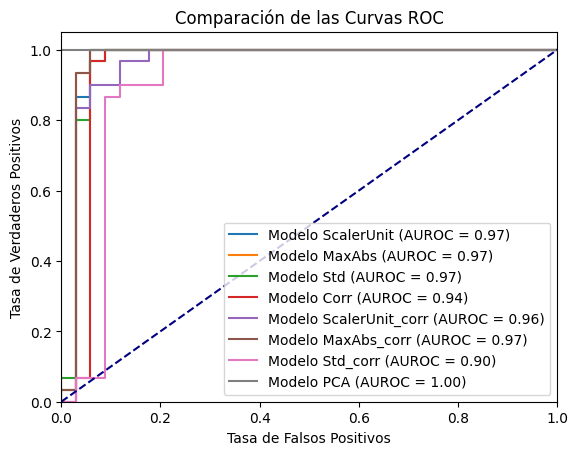

In [91]:
# Visualización de la curva ROC Var:
# plt.plot(fpr_var, tpr_var, label='Modelo Var (AUROC = %0.2f)' % roc_auc_var)

# Visualización de la curva ROC ScalerUnit:
plt.plot(fpr_scalerUnit, tpr_scalerUnit, label='Modelo ScalerUnit (AUROC = %0.2f)' % roc_auc_scalerUnit)

# Visualización de la curva ROC MaxAbs:
plt.plot(fpr_MaxAbs, tpr_MaxAbs, label='Modelo MaxAbs (AUROC = %0.2f)' % roc_auc_MaxAbs)

# Visualización de la curva ROC Std:
plt.plot(fpr_Std, tpr_Std, label='Modelo Std (AUROC = %0.2f)' % roc_auc_Std)

# Visualización de la curva ROC Corr:
plt.plot(fpr_corr, tpr_corr, label='Modelo Corr (AUROC = %0.2f)' % roc_auc_corr)

# Visualización de la curva ROC ScalerUnit_corr:
plt.plot(fpr_ScalerUnit_corr, tpr_ScalerUnit_corr, label='Modelo ScalerUnit_corr (AUROC = %0.2f)' % roc_auc_ScalerUnit_corr)

# Visualización de la curva ROC MaxAbs_corr:
plt.plot(fpr_MaxAbs_corr, tpr_MaxAbs_corr, label='Modelo MaxAbs_corr (AUROC = %0.2f)' % roc_auc_MaxAbs_corr)

# Visualización de la curva ROC Std:
plt.plot(fpr_Std_corr, tpr_Std_corr, label='Modelo Std_corr (AUROC = %0.2f)' % roc_auc_Std_corr)

# Visualización de la curva ROC PCA:
plt.plot(fpr_pca, tpr_pca, label='Modelo PCA (AUROC = %0.2f)' % roc_auc_pca)



# Curva de no discriminación
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Configuración de los límites del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Etiquetas y título
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de las Curvas ROC')
plt.legend(loc="lower right")

# Mostrar la gráfica
plt.show()

In [92]:
def calcular_media(valores):
    if len(valores) == 0:
        return None  # Devuelve None si no hay valores
    return sum(valores) / len(valores)

# Ejemplo de uso
print("ScalerUnit:", calcular_media([1, .98, 1, 1, 1, .97, .97, .97, .98, 1, 1]))
print("MaxAbs:", calcular_media([1, .98, 1, 1, 1, .97, .97, .95, .98, 1, 1]))
print("Std:", calcular_media([1, .95, 1 , .97, 1, .97, .97, .95, .98, .95, .98]))
print("Corr:", calcular_media([.97, .95, .97, .97, .9, 1, .92, .97, .91, .97, .95]))
print("ScalerUnit_corr:", calcular_media([1, .98, 1, .92, .92, .97, .92, .95, .95, .95, .93]))
print("MaxAbs_corr:", calcular_media([1, .98, 1, 1, 1, .97, .97, .95, .98, 1, 1]))
print("Std_corr:", calcular_media([1, .93, 1, .98, .9, .94, .95, .95, .93, .97, .95]))
print("PCA:", calcular_media([1, .95, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

ScalerUnit: 0.9881818181818182
MaxAbs: 0.9863636363636363
Std: 0.9745454545454545
Corr: 0.9527272727272726
ScalerUnit_corr: 0.9536363636363635
MaxAbs_corr: 0.9863636363636363
Std_corr: 0.9545454545454546
PCA: 0.9954545454545454


Nos quedamos con el modelo PCA debido a que es el que más aciertos tiene

In [93]:
def guardar_predicciones_decodificadas(predicciones_codificadas, decodificacion_dict):
    predicciones_decodificadas = []    # Crear una lista para almacenar las predicciones decodificadas
   
    for prediccion_codificada in predicciones_codificadas:    # Decodificar las predicciones
        clase_decodificada = [clave for clave, valor in decodificacion_dict['class'].items() if valor == round(prediccion_codificada)][0]
        predicciones_decodificadas.append(clase_decodificada)

    df_predicciones = pd.DataFrame({'Predicciones Decodificadas': predicciones_decodificadas})    # Crear un DataFrame con las predicciones decodificadas 
    return df_predicciones

df_predicciones = guardar_predicciones_decodificadas(y_score_pca, encoding_dict_y)

# Guardar el dataframe en un fichero csv
df_predicciones.to_csv('predicciones_etiquetas.csv', index=True)

# Lo repetimos para los datos de test reales:

In [94]:
# Descargamos los datos del test: 
data = pd.read_csv('C:/Users/Diego/OneDrive - Universidad Rey Juan Carlos/Documentos/GIA_URJC/Curso 2023-24/G.-IA/Curso_2/Cuatri_2/AprendizajeAutomatico_1/Practicas/Practica_1/Datos/testX_reto1.csv', sep=';', decimal='.', index_col=0, na_values='?')
data.shape

(80, 24)

In [95]:
#-- CODIFICACIÓN DE LOS DATOS --#

# Codificación de los datos:
data = apply_encoding(data, encoding_dict_x)

# Crear columna dummies valores NaN
for col in data.columns:
    data[col + '_isna'] = data[col].isna().astype(int)

# Sustitución de valores NaN por valor 'mean' columnas 'rbc':
mean_rbc = data['rbc'].mean()
data['rbc'].fillna(mean_rbc, inplace=True)

#-- IMPUTACIÓN MULTIVARIANTE --#

# Creas una copia del DataFrame original:
data_copy = data.copy()

# Imputación multivariante de los datos NaN:
data_imputed = imputer.transform(data_copy)
data = pd.DataFrame(data_imputed, columns=data.columns)              # Convertir de nuevo a DataFrame

# Estandarizamos primero:
data_std = scaler.transform(data)

# Hacemos el transform:
data_pca = pca.transform(data_std)

y_data_pca = reg_model_pca.predict(data_pca)


Tamaño del DataFrame original:  (80, 48)
Tamaño del DataFrame tras PCA:  (80, 23)


In [96]:
data_predicciones = guardar_predicciones_decodificadas(y_data_pca, encoding_dict_y)

# Guardar el dataframe en un fichero csv
data_predicciones.to_csv('predicciones_etiquetas.csv', index=True)